In [93]:
import sympy as sy
import numpy as np
from scipy import stats
import ppdl
from scipy.integrate import quad
import matplotlib.pyplot as plt
from rlxutils import subplots
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

load the expression of the gaussian distribution pdf

In [2]:
z, x, s, mu, sigma = sy.symbols("z x s \mu \sigma")
g = ppdl.gaussian(x, mu, sigma)
g

sqrt(2)*exp(-0.5*(-\mu + x)**2/\sigma**2)/(2*sqrt(pi)*\sigma)

In [67]:
prior = g.subs({mu: 20, sigma: 3})
likelihood = g.subs({mu: 22.3, sigma: 1})
likelihood*prior


exp(-248.645*(0.0448430493273543*x - 1)**2)*exp(-0.0555555555555556*(x - 20)**2)/(6*pi)

# the posterior of one measurement

In [87]:
# experiment parameters
z_real = 23
prior_mean = 20
prior_std = 3# if large, it would represent a very uninformative prior
sensor_sigma = 1  # sensor uncertainty

# the measurement
measurement = np.random.normal(loc=z_real, scale=sensor_sigma)

xr = np.linspace(z_real-2,z_real+2,1000)

sqrt(2)*exp(-0.5*(z/3 - 20/3)**2)/(6*sqrt(pi))

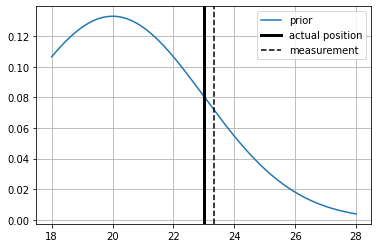

In [88]:
# our prior
P_z = ppdl.gaussian(z,prior_mean,prior_std)

zr = np.linspace(z_real-5,z_real+5,1000)

# plot prior
plt.plot(zr, sy.lambdify(z, P_z, "numpy")(zr), label="prior")
#plt.ylim(0,0.5); 
plt.grid();
plt.axvline(z_real, color="black", lw=3, label="actual position")
plt.axvline(measurement, color="black", ls="--", label="measurement")
plt.legend();
P_z

sqrt(2)*exp(-272.322301590501*(1 - 0.0428492670608954*z)**2)/(2*sqrt(pi))

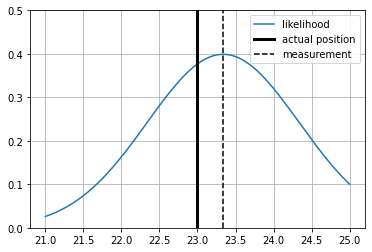

In [94]:
# the likelihood --> observe how it is centered in our observation
P_s_given_z = ppdl.gaussian(measurement, z, sensor_sigma)

# plot the likelihood
plt.plot(xr, sy.lambdify(z, P_s_given_z, "numpy")(xr), label="likelihood")
plt.ylim(0,0.5); plt.grid();
plt.axvline(z_real, color="black", lw=3, label="actual position")
plt.axvline(measurement, color="black", ls="--", label="measurement")
plt.legend();

P_s_given_z

In [99]:
# the numerator
P_s_given_z * P_z

exp(-272.322301590501*(1 - 0.0428492670608954*z)**2)*exp(-0.5*(z/3 - 20/3)**2)/(6*pi)

In [100]:
(P_s_given_z * P_z).integrate(z)

2.00810946398597e-129*Integral(exp(25.5598442772003*z)*exp(-0.555555555555555*z**2), z)/pi

In [90]:
# the normalizing constant
P_s = quad(sy.lambdify(z, P_s_given_z * P_z, "numpy"), -10,50)[0]
P_s

0.07227932667609259

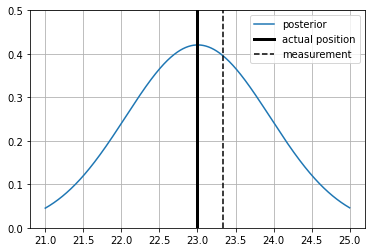

In [92]:
# the posterior, observe how it balances the prior and the likelihood
P_z_given_s = P_s_given_z * P_z / P_s

# plot the likelihood
plt.plot(xr, sy.lambdify(z, P_z_given_s, "numpy")(xr), label="posterior")
plt.ylim(0,0.5); plt.grid();
plt.axvline(z_real, color="black", lw=3, label="actual position")
plt.axvline(measurement, color="black", ls="--", label="measurement")
plt.legend();

# several measurements

we repeat the steps above, using the posterior obtained at each step as the prior for next measurement

In [44]:

def estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = 10,
    sensor_sigma = .7
):

    # initial prior
    P_z = ppdl.gaussian(z,prior_mean,prior_std)
    measurements = np.random.normal(loc=z_real, scale=sensor_sigma, size=10)

    xr = np.linspace(z_real-5,z_real+5,1000)
    nP_z = []
    nP_z.append(sy.lambdify(z, P_z, "numpy")(xr)) 

    for i in range(10):
        # the likelihood
        P_s_given_z = ppdl.gaussian(measurements[i], z, sensor_sigma)
        
        # the normalizing factor
        P_s = quad(sy.lambdify(z, P_s_given_z * P_z, "numpy"), -10,50)[0]
        
        # the posterior (Bayes Theorem)
        P_z_given_s = P_s_given_z * P_z / P_s

        # the posterior becomes new prior for next measurement
        P_z = P_z_given_s 

        # store for plotting
        nP_z.append(sy.lambdify(z, P_z_given_s, "numpy")(xr))    

    
    # plot posteriors at each step    
    for ax,i in subplots(len(nP_z), n_cols=6):
        plt.plot(xr, nP_z[i], label="posterior")
        plt.grid()
        plt.axvline(z_real, color="black", label="real position")
        if i>0:
            plt.axvline(measurements[i-1], color="black", ls="--", label="measurement") 
        if i==0:
            plt.title("prior")
            plt.xlim(z_real-5, z_real+5)
            plt.ylim(0,.5)
        else:
            plt.title(f"measurement {i}")
            plt.xlim(z_real-2, z_real+2)
        
        if i==10:
            plt.legend()
#            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

## a very uninformative prior 

observe how, as measurements are processed, the posterior becomes narrower (less uncertainty) and approaches the real value

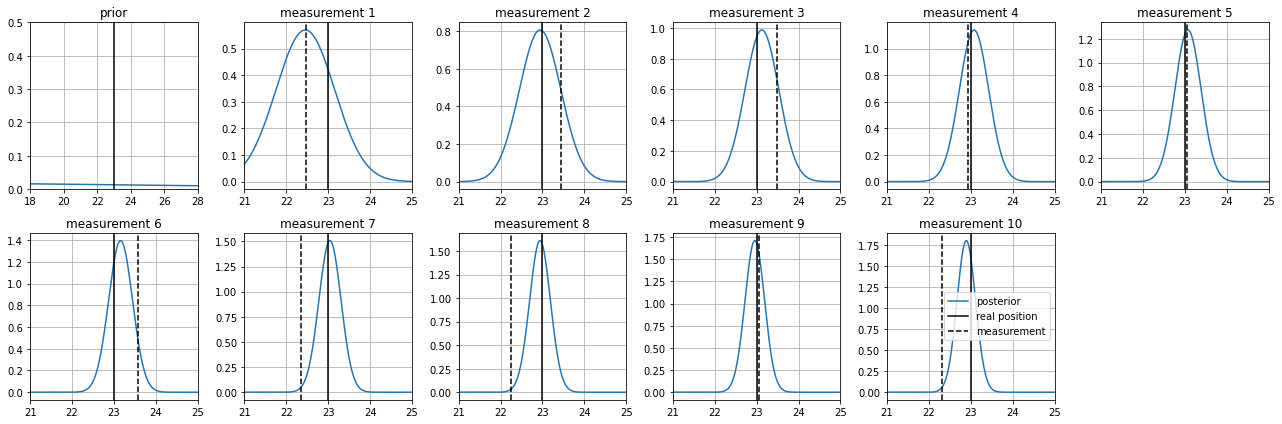

In [28]:

estimate_position(
    z_real = 23,
    prior_mean = 5,
    prior_std = 20,
    sensor_sigma = .7
)

## a more accurate sensor converges faster and with less ucertainty

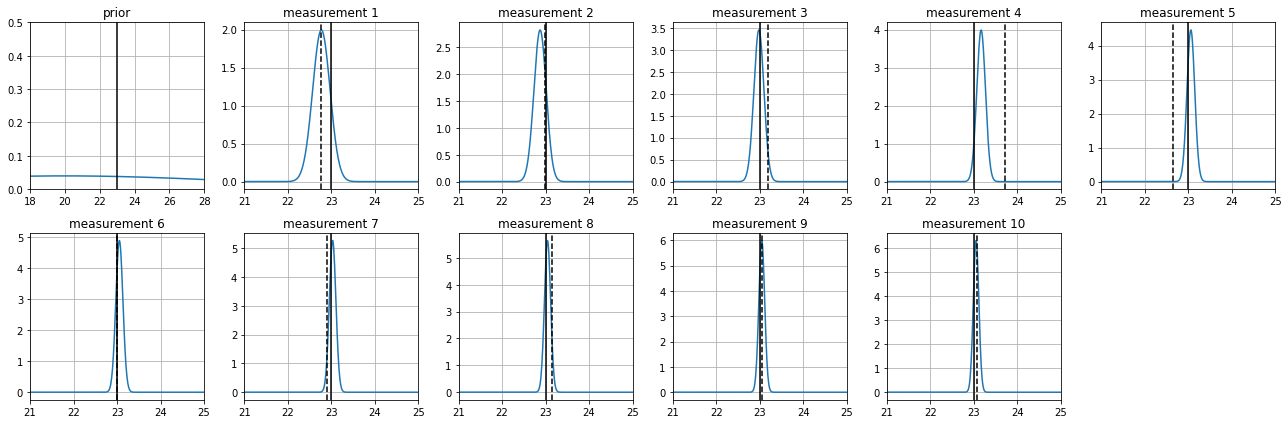

In [18]:

estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = 10,
    sensor_sigma = .2
)

## but if we are very wrong and very confident on our prior, we pay for it

Wrong mean with a very narrow stdev. It takes many measurements to converge to the real value.

Recall, narrow stdevs anywhere always represent small uncertainty

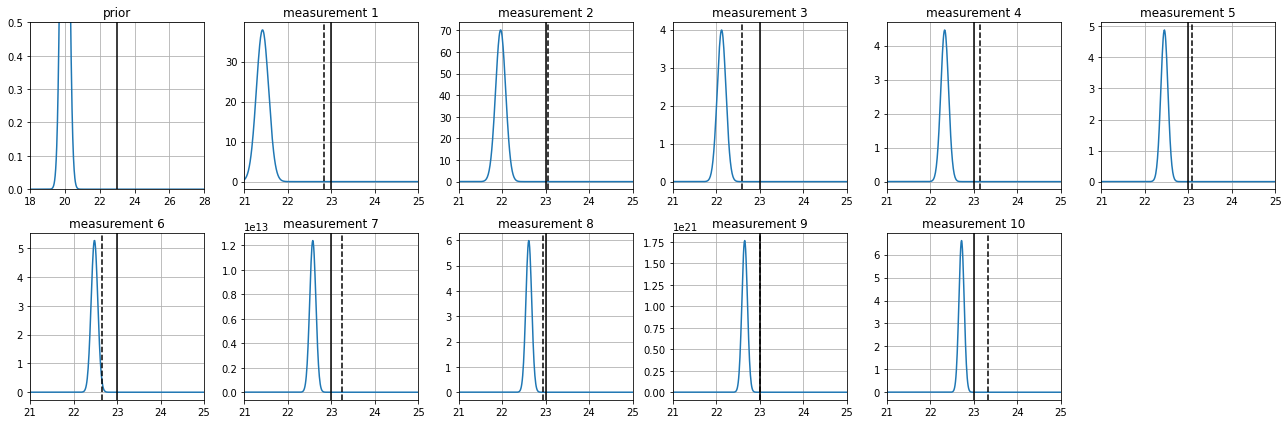

In [19]:

estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = .2,
    sensor_sigma = .2
)